In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, uniform

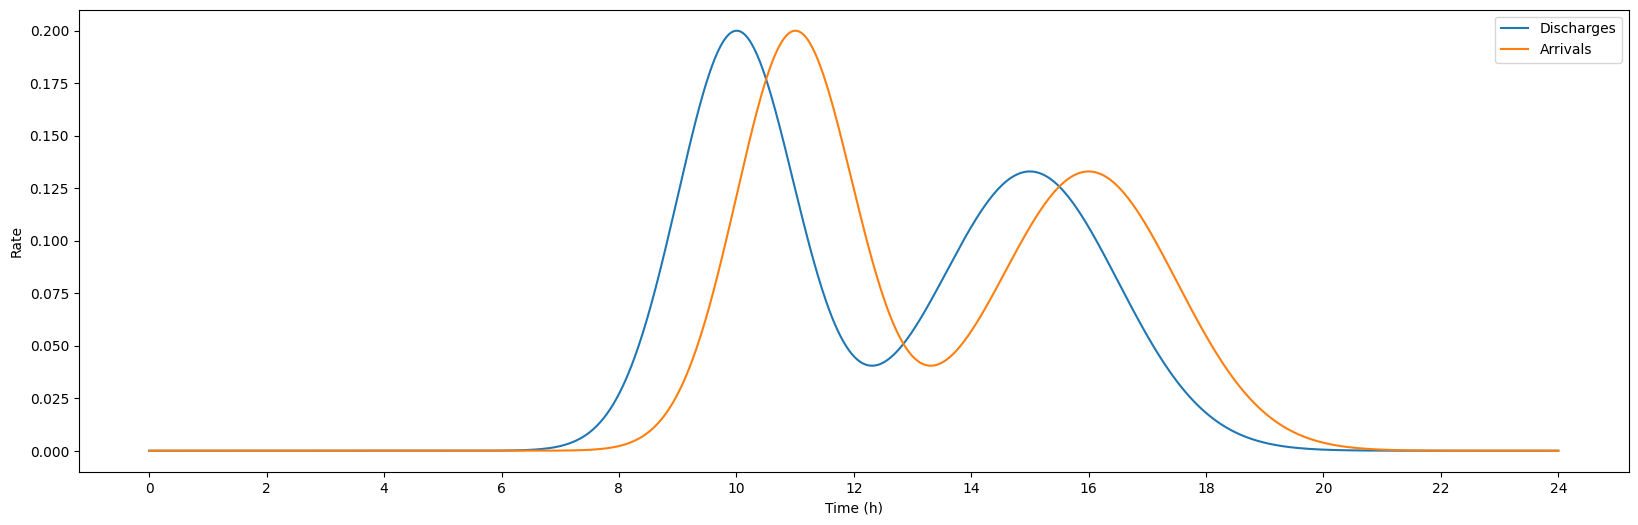

In [2]:
p = 0.55
t = np.linspace(0, 24, 1000)

class ArrivalDistribution:
    first_round_time = 9
    second_round_time = 15
    def __init__(self, p=0.5, offset=0):
        self.p = p
        self.first_peak = norm(loc=10 + offset, scale=1)
        self.second_peak = norm(loc=15 + offset, scale=1.5)

    def pdf(self, x):
        return self.p * self.first_peak.pdf(x) + (1 - self.p) * self.second_peak.pdf(x)

    def rvs(self, size=()):
        s1 = self.first_peak.rvs(size=size)
        s2 = self.second_peak.rvs(size=size)
        choice = uniform.rvs(size=size) < self.p
        return np.where(choice, s1, s2)

discharge_dist = ArrivalDistribution()
admission_dist = ArrivalDistribution(offset=1)


fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.plot(t, discharge_dist.pdf(t), label="Discharges")
ax.plot(t, admission_dist.pdf(t), label="Arrivals")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Rate")
ax.set_xticks(np.arange(0, 25, 2), np.arange(0, 25, 2))
ax.legend()
plt.show()

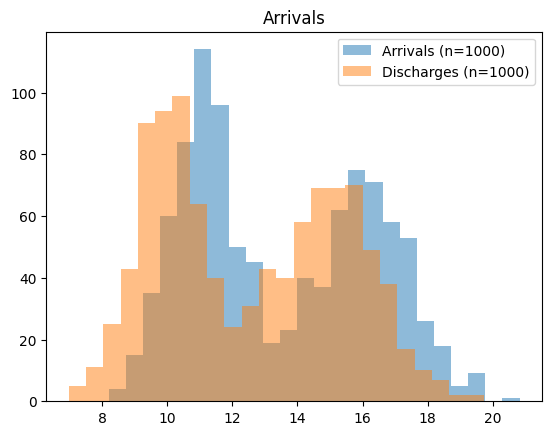

In [3]:
arrivals = admission_dist.rvs(size=1000)
discharges = discharge_dist.rvs(size=1000)

plt.title("Arrivals")
plt.hist(arrivals, alpha=0.5, bins=24, label=f"Arrivals (n={len(arrivals)})")
plt.hist(discharges, alpha=0.5, bins=24, label=f"Discharges (n={len(discharges)})")
plt.legend()
plt.show()

In [10]:
from heapq import heapify, heappop, heappush
from dataclasses import dataclass
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tqdm import tqdm

In [5]:
@dataclass
class Event:
    time: float

    def __lt__(self, other):
        return self.time < other.time

@dataclass
class PatientAdmitted(Event):
    ward_id: int

@dataclass
class PatientDischarged(Event):
    ward_id: int

@dataclass
class BedArrivedWashing(Event):
    pass

@dataclass
class BedfinishedWashing(Event):
    pass


In [35]:
def plot_queue_length(results):
    plt.figure(figsize=(12, 6))
    plt.title('Queue Length Over Time in Blocking System')
    # for run in results:
    plt.plot(results[1], results[2], label='Queue Length')
    
    plt.xlabel('Time')
    plt.ylabel('Queue Length')
    plt.show()



## Current assumptions
- Bot teleports when not pushing bed
- Transportation time only occurs over the 175m distance in logistic room, e.g. not elevator to dirty buffer


## Issues
- What happens if two beds come immediately after each other? 
    - The bot should be occupied with the first bed until it is done, so the second bed should wait.

51


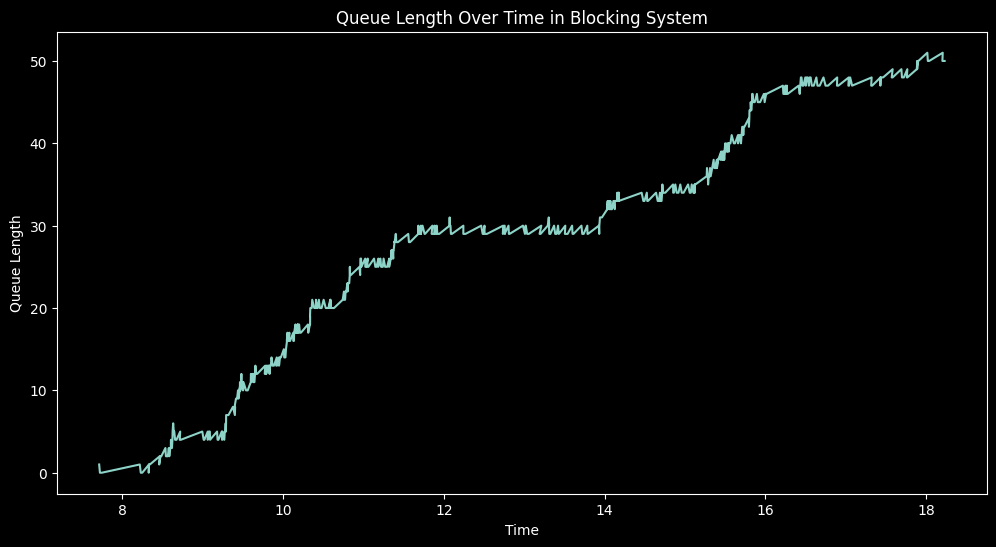

In [ ]:
def simulate_system(
        admission_dist : callable,
        discharge_dist : callable,
        service_time_dist : callable,
        transport_time_dist : callable,
        n_patients: int = 200
    ):

    admission_times = admission_dist.rvs(size=n_patients)
    discharge_times = discharge_dist.rvs(size=n_patients)

    # events = [PatientAdmitted(time, 0) for time in admission_times]
    events = [PatientDischarged(time, 0) for time in discharge_times]
    heapify(events)

    events_processed = []

    dirty_buffer = 0
    clean_buffer = 0
    
    buffer_sizes = []
    times = []

    washer_ready = True
    busy_until = 0.0

    while events:
        event = heappop(events)
        
        match event:
            case PatientDischarged(time=t):
                dirty_buffer += 1
                transport_time = transport_time_dist()  # Elevator -> Washing
                heappush(events, BedArrivedWashing(t + transport_time + busy_until))
                busy_until += transport_time

            case BedArrivedWashing(time=t):
                if washer_ready:
                    washer_ready = False
                    dirty_buffer -= 1
                    
                    transport_time = transport_time_dist()  # Clean buffer -> ward
                    heappush(events, BedfinishedWashing(t + service_time_dist() + transport_time))
                    
            case BedfinishedWashing(time=t):
                clean_buffer += 1

                if washer_ready and dirty_buffer > 0:
                    washer_ready = False
                    dirty_buffer -= 1
                    
                    transport_time = transport_time_dist()  # Clean buffer -> ward
                    heappush(events, BedfinishedWashing(t + service_time_dist() + transport_time))
                else:
                    washer_ready = True
        
        buffer_sizes.append(dirty_buffer)
        times.append(event.time)
            

        events_processed.append(event)

    return events_processed, np.array(times), np.array(buffer_sizes)

# np.random.seed(42)
service_min_time = 1/120  # 10 minute
service_time_dist = lambda: service_min_time + expon(scale=1e-10).rvs()
transport_time_dist = lambda: norm(loc=1/120, scale=1e-2).rvs()  # 1/2 minute to transport a bed
results = simulate_system(admission_dist, discharge_dist, service_time_dist, transport_time_dist, n_patients=200)
print(f"{np.max(results[2])}")  # 10
plot_queue_length(results)